In [1]:
import os
import os.path
from pathlib import Path
from datetime import datetime, date
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir('..')


In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

Download ~1.3GB parquet files (from 2012-12 to 2022-11)

In [3]:
from cloudpathlib import CloudPath
if not os.path.exists("market-archive-v2"):
    cp = CloudPath("s3://steam-bot-public/market-archive-v2/")
    cp.download_to("market-archive-v2")

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName('myAppName') \
    .config("spark.executor.memory", "5g") \
    .config("spark.driver.memory", "1g")\
    .config("spark.sql.shuffle.partitions" , "30") \
    .config('spark.sql.files.maxPartitionBytes', str(200 * 1024 * 1024))\
    .getOrCreate()

In [5]:
import pyspark.sql.functions as func
from pyspark.sql.types import DecimalType, Row
from pyspark.sql import Window as W

In [6]:
df = spark.read.parquet("parquet")

Drop rows with timestamp after 2022-11-01

In [7]:
df = df.filter(df.timestamp < datetime(2022, 11, 1))

In [8]:
df.count()

209032603

In [9]:
df.printSchema()

root
 |-- app_id: long (nullable = true)
 |-- market_hash_name: string (nullable = true)
 |-- currency: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- price: double (nullable = true)
 |-- amount: long (nullable = true)
 |-- market_fee: double (nullable = true)
 |-- price_no_fee: double (nullable = true)
 |-- game_fee: double (nullable = true)
 |-- steam_fee: double (nullable = true)
 |-- partition: string (nullable = true)



In [10]:
df.rdd.getNumPartitions()

35

In [11]:
df.show()

+------+--------------------+--------+-------------------+-----+------+----------+------------+--------+---------+---------+
|app_id|    market_hash_name|currency|          timestamp|price|amount|market_fee|price_no_fee|game_fee|steam_fee|partition|
+------+--------------------+--------+-------------------+-----+------+----------+------------+--------+---------+---------+
|   730|Winter Offensive ...|       1|2022-10-01 04:00:00| 5.03|     8|       0.1|        4.39|    0.43|     0.21|  2022-10|
|   730|Sticker | Jame | ...|       1|2022-10-01 04:00:00| 0.03|    70|       0.1|        0.01|    0.01|     0.01|  2022-10|
|   730|Winter Offensive ...|       1|2022-10-02 04:00:00| 4.51|     9|       0.1|        3.93|    0.39|     0.19|  2022-10|
|   730|Sticker | Jame | ...|       1|2022-10-02 04:00:00| 0.03|   136|       0.1|        0.01|    0.01|     0.01|  2022-10|
|   730|Winter Offensive ...|       1|2022-10-03 04:00:00| 4.45|    34|       0.1|        3.88|    0.38|     0.19|  2022-10|


In [12]:
df.groupby("market_hash_name").sum("amount").sort("sum(amount)", ascending=False).show()

+--------------------+-----------+
|    market_hash_name|sum(amount)|
+--------------------+-----------+
|         Clutch Case|  133790698|
|        Gamma 2 Case|  121795266|
|       Chroma 3 Case|  101550358|
|    Danger Zone Case|   96192803|
|Operation Breakou...|   90845485|
|       Chroma 2 Case|   88661875|
|     Spectrum 2 Case|   85193903|
|Operation Phoenix...|   75849120|
|          Glove Case|   74902384|
|       Prisma 2 Case|   72867492|
|         Prisma Case|   70937735|
|       Fracture Case|   60422159|
|          Gamma Case|   58567186|
|       Spectrum Case|   57543443|
|       Falchion Case|   50566853|
|        Horizon Case|   45241971|
|         Shadow Case|   41639580|
|         Chroma Case|   41072659|
|           CS20 Case|   37726406|
|       Revolver Case|   37710024|
+--------------------+-----------+
only showing top 20 rows



In [13]:
df \
  .groupby("market_hash_name") \
  .agg( \
    func.sum(df.amount).alias("total_amount"), \
    func.round(func.avg(df.price), 2).alias("avg_price"), \
    func.sum(df.price * df.amount).cast(DecimalType(38, 2)).alias("total_volume") \
  ) \
  .sort("total_volume", ascending=False) \
  .show(20, False)

+------------------------------------+------------+---------+------------+
|market_hash_name                    |total_amount|avg_price|total_volume|
+------------------------------------+------------+---------+------------+
|Mann Co. Supply Crate Key           |28706708    |2.32     |66221081.02 |
|AK-47 | Redline (Field-Tested)      |5080320     |11.47    |40485978.72 |
|Operation Breakout Weapon Case      |90845485    |1.18     |28777779.13 |
|Glove Case                          |74902384    |1.18     |27068850.18 |
|Clutch Case                         |133790698   |0.21     |24897685.55 |
|Operation Broken Fang Case          |29509368    |1.35     |23263196.95 |
|AWP | Asiimov (Battle-Scarred)      |760276      |41.33    |22892897.32 |
|GAMESCOM INVITATIONAL CRATE         |6570269     |0.92     |20787494.65 |
|★ M9 Bayonet | Doppler (Factory New)|59758       |405.02   |20553908.39 |
|Dreams & Nightmares Case            |17843727    |0.87     |20182635.04 |
|Fracture Case           

In [14]:
df \
  .groupby("app_id", "market_hash_name") \
  .agg( \
    func.sum(df.amount).alias("total_amount"), \
    func.round(func.avg(df.price), 2).alias("avg_price"), \
    func.round(func.min(df.price), 2).alias("min_price"), \
    func.round(func.max(df.price), 2).alias("max_price"), \
    func.sum(df.game_fee * df.amount).cast(DecimalType(38, 2)).alias("total_game_fee"), \
    func.sum(df.steam_fee * df.amount).cast(DecimalType(38, 2)).alias("total_steam_fee"), \
    func.sum(df.price * df.amount).cast(DecimalType(38, 2)).alias("total_volume") \
  ) \
  .sort("total_volume", ascending=False) \
  .show(50, False)

+------+----------------------------------------+------------+---------+---------+---------+--------------+---------------+------------+
|app_id|market_hash_name                        |total_amount|avg_price|min_price|max_price|total_game_fee|total_steam_fee|total_volume|
+------+----------------------------------------+------------+---------+---------+---------+--------------+---------------+------------+
|440   |Mann Co. Supply Crate Key               |28706708    |2.32     |1.53     |2.55     |5633932.78    |2738576.07     |66221081.02 |
|730   |AK-47 | Redline (Field-Tested)          |5080320     |11.47    |4.24     |42.85    |3497811.76    |1735426.80     |40485978.72 |
|730   |Operation Breakout Weapon Case          |90845485    |1.18     |0.03     |4.72     |2832510.29    |1715998.97     |28777779.13 |
|730   |Glove Case                              |74902384    |1.18     |0.03     |8.16     |2547564.46    |1502512.73     |27068850.18 |
|730   |Clutch Case                      

Compute market volume for each app

In [15]:
df \
  .groupby("app_id") \
  .agg( \
    func.sum(df.amount).alias("total_sold_amount"), \
    func.round(func.avg(df.price), 2).alias("avg_price"), \
    func.sum(df.price * df.amount).cast(DecimalType(38, 2)).alias("total_sold_volume"), \
    func.min(df.price).cast(DecimalType(38, 2)).alias("min_price"), \
    func.max(df.price).cast(DecimalType(38, 2)).alias("max_price"), \
    func.sum(df.game_fee * df.amount).cast(DecimalType(38, 2)).alias("total_game_fee"), \
    func.sum(df.steam_fee * df.amount).cast(DecimalType(38, 2)).alias("total_steam_fee"), \
    func.count_distinct(df.market_hash_name).alias("market_items_amount") \
  ) \
  .sort("total_sold_volume", ascending=False) \
  .show()

+------+-----------------+---------+-----------------+---------+---------+--------------+---------------+-------------------+
|app_id|total_sold_amount|avg_price|total_sold_volume|min_price|max_price|total_game_fee|total_steam_fee|market_items_amount|
+------+-----------------+---------+-----------------+---------+---------+--------------+---------------+-------------------+
|   730|       4249532657|    18.44|    4225655124.20|     0.03|  2008.57|  371469714.16|   195678825.90|              16030|
|   570|        924839914|     1.89|     882180873.75|     0.03|  1996.47|   77807190.57|    41087378.20|              28047|
|578080|        307944542|     5.98|     350277164.48|     0.03|  1946.11|   31008695.24|    16140135.97|                352|
|   440|        220818704|     4.92|     247946911.69|     0.03|  1805.22|   21509000.63|    11062915.91|              27678|
|   753|       2289810026|     0.14|     174302443.45|     0.03|   870.38|   25430683.67|    23647827.71|             

Find all CS:GO knifes and gloves that has been sold by price lower than 10$

In [16]:
star_pattern = '^\u2605'  # \u2605 is the Unicode codepoint for the star character

df \
  .filter(df.app_id == 730) \
  .filter(func.regexp_extract(func.col("market_hash_name"), star_pattern, 0) != '') \
  .groupby("market_hash_name") \
  .agg( \
    func.sum(df.amount).alias("total_amount"), \
    func.round(func.avg(df.price), 2).alias("avg_price"), \
    func.min(df.price).cast(DecimalType(38, 2)).alias("min_price"), \
    func.max(df.price).cast(DecimalType(38, 2)).alias("max_price"), \
    func.count(func.when(df.price < 10, df.price)).alias("cheap_amount") \
  ) \
  .filter(func.col("cheap_amount") > 0) \
  .sort("cheap_amount", ascending=False) \
  .show(100000, False)

+------------------------------------------------------------+------------+---------+---------+---------+------------+
|market_hash_name                                            |total_amount|avg_price|min_price|max_price|cheap_amount|
+------------------------------------------------------------+------------+---------+---------+---------+------------+
|★ StatTrak™ Butterfly Knife | Boreal Forest (Field-Tested)  |3043        |188.19   |0.11     |690.00   |6           |
|★ Flip Knife | Urban Masked (Well-Worn)                     |3963        |67.1     |0.53     |135.23   |6           |
|★ Shadow Daggers | Scorched (Well-Worn)                     |2687        |58.62    |0.43     |386.68   |5           |
|★ StatTrak™ Bayonet | Stained (Well-Worn)                   |814         |136.2    |0.03     |280.12   |5           |
|★ Flip Knife | Case Hardened (Factory New)                  |960         |143.96   |0.03     |461.08   |5           |
|★ Gut Knife | Boreal Forest (Battle-Scarred)   

In [17]:
sum_df = df \
  .withColumn("timestamp", func.date_trunc("mon", df.timestamp)) \
  .groupby("app_id", "timestamp") \
  .agg( \
    func.sum(df.price * df.amount).alias("total_volume"), \
    func.sum(df.amount).alias("total_amount") \
  ) \
  .coalesce(1) \
  .orderBy("timestamp") \
  .cache()

total_df = sum_df \
  .groupby("timestamp") \
  .agg( \
    func.sum(sum_df.total_volume).alias("total_volume"), \
    func.sum(sum_df.total_amount).alias("total_amount") \
  ) \
  .orderBy("timestamp") \
  .cache()

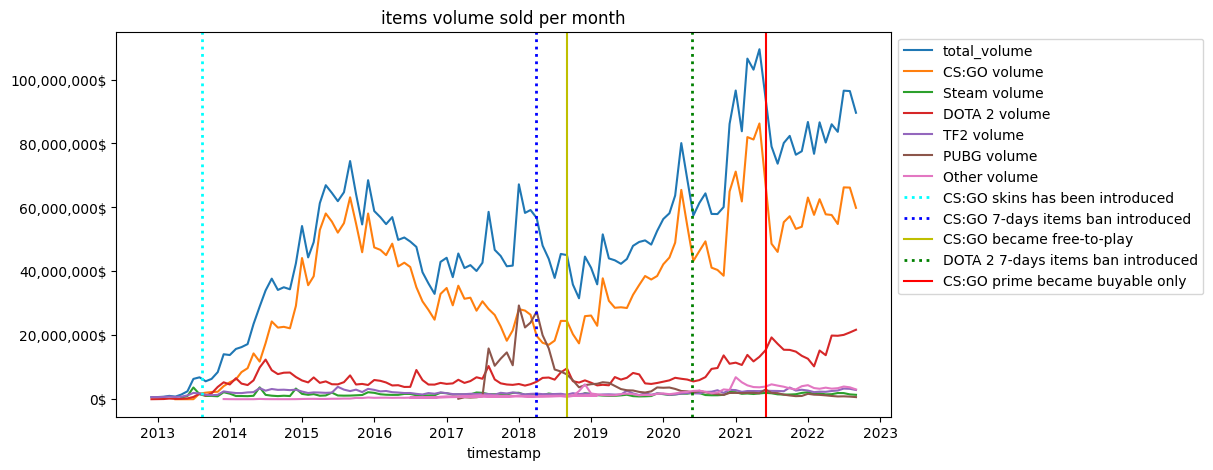

In [18]:
plot_end = datetime(2022, 10, 1) 

total_x = [val.timestamp for val in total_df.filter(total_df.timestamp < plot_end).select('timestamp').collect()]
total_y = [val.total_volume for val in total_df.filter(total_df.timestamp < plot_end).select('total_volume').collect()]

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.plot(total_x, total_y, label='total_volume')

APP_IDS = {730: "CS:GO", 753: "Steam", 570: "DOTA 2", 440: "TF2", 578080: "PUBG"}

for app_id, name in APP_IDS.items():
    app_df = sum_df.filter(sum_df.app_id == app_id)
    y_val = [val.total_volume for val in app_df.filter(app_df.timestamp < plot_end).select('total_volume').collect()]
    x_ts = [val.timestamp for val in app_df.filter(app_df.timestamp < plot_end).select('timestamp').collect()]
    plt.plot(x_ts, y_val, label=f'{name} volume')

other_app_df = sum_df
for app_id in APP_IDS.keys():
    other_app_df = other_app_df.filter(other_app_df.app_id != app_id)
other_app_df = other_app_df.groupby("timestamp") \
  .agg( \
    func.sum(sum_df.total_volume).alias("total_volume"), \
  ) \
  .cache()
y_val = [val.total_volume for val in other_app_df.filter(other_app_df.timestamp < plot_end).select('total_volume').collect()]
x_ts = [val.timestamp for val in other_app_df.filter(other_app_df.timestamp < plot_end).select('timestamp').collect()]
plt.plot(x_ts, y_val, label='Other volume')
    
plt.xlabel('timestamp')
plt.title('items volume sold per month')

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')+"$"))
plt.axvline(x=datetime(2013, 8, 14), color='aqua', ls=':', lw=2, label='CS:GO skins has been introduced')
plt.axvline(x=datetime(2018, 3, 30), color='b', ls=':', lw=2, label='CS:GO 7-days items ban introduced')
plt.axvline(x=datetime(2018, 8, 30), color='y', label='CS:GO became free-to-play')
plt.axvline(x=datetime(2020, 5, 26), color='g', ls=':', lw=2, label='DOTA 2 7-days items ban introduced')
plt.axvline(x=datetime(2021, 6, 3), color='r', label='CS:GO prime became buyable only')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

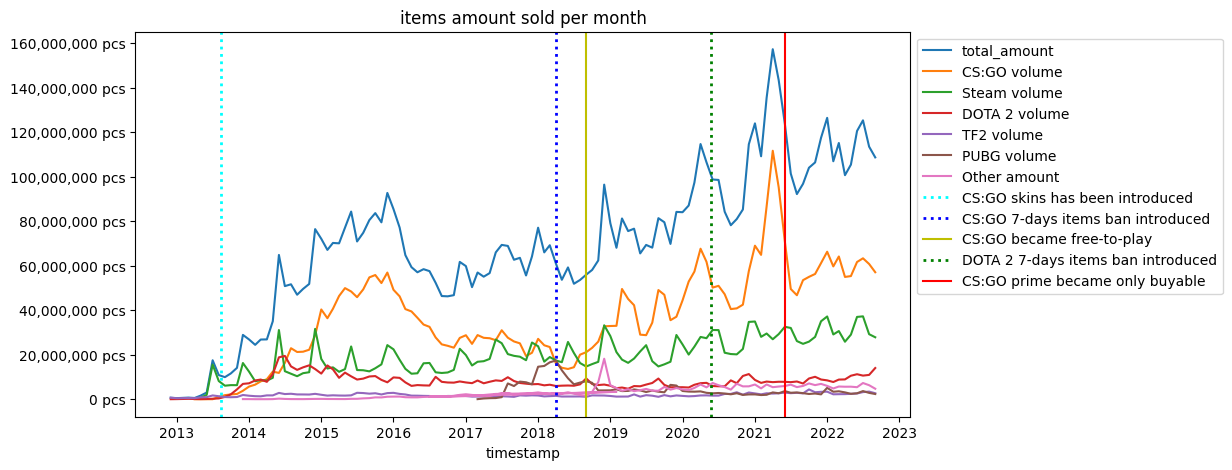

In [19]:
plot_end = datetime(2022, 10, 1) 

total_x = [val.timestamp for val in total_df.filter(total_df.timestamp < plot_end).select('timestamp').collect()]
total_y = [val.total_amount for val in total_df.filter(total_df.timestamp < plot_end).select('total_amount').collect()]

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.plot(total_x, total_y, label='total_amount')

APP_IDS = {730: "CS:GO", 753: "Steam", 570: "DOTA 2", 440: "TF2", 578080: "PUBG"}

for app_id, name in APP_IDS.items():
    app_df = sum_df.filter(sum_df.app_id == app_id)
    y_val = [val.total_amount for val in app_df.filter(app_df.timestamp < plot_end).select('total_amount').collect()]
    x_ts = [val.timestamp for val in app_df.filter(app_df.timestamp < plot_end).select('timestamp').collect()]
    plt.plot(x_ts, y_val, label=f'{name} volume')

other_app_df = sum_df
for app_id in APP_IDS.keys():
    other_app_df = other_app_df.filter(other_app_df.app_id != app_id)
other_app_df = other_app_df.groupby("timestamp") \
  .agg( \
    func.sum(sum_df.total_amount).alias("total_amount") \
  ) \
  .cache()
y_val = [val.total_amount for val in other_app_df.filter(other_app_df.timestamp < plot_end).select('total_amount').collect()]
x_ts = [val.timestamp for val in other_app_df.filter(other_app_df.timestamp < plot_end).select('timestamp').collect()]
plt.plot(x_ts, y_val, label='Other amount')

plt.xlabel('timestamp')
plt.title('items amount sold per month')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')+" pcs"))
plt.axvline(x=datetime(2013, 8, 14), color='aqua', ls=':', lw=2, label='CS:GO skins has been introduced')
plt.axvline(x=datetime(2018, 3, 30), color='b', ls=':', lw=2, label='CS:GO 7-days items ban introduced')
plt.axvline(x=datetime(2018, 8, 30), color='y', label='CS:GO became free-to-play')
plt.axvline(x=datetime(2020, 5, 26), color='g', ls=':', lw=2, label='DOTA 2 7-days items ban introduced')
plt.axvline(x=datetime(2021, 6, 3), color='r', label='CS:GO prime became only buyable')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()